In [1]:
!pip install pykan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 4.1 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from kan import KAN as PyKAN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch import nn, optim
from tqdm import tqdm

plt.rcParams.update({'font.size': 18})
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fault Detection
In this notebook we'll train a `PyKAN` network to distinguish between *faulty* and *not-faulty* operating regimes.

## Load dataset

In [87]:
df_x = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/X_train_pre.csv")
df_y = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/y_train_pre.csv")

In [88]:
print(df_x.columns)

Index(['id', 'oat', 'mgt', 'pa', 'ias', 'np', 'ng', 'np_ng_ratio', 'da',
       'oat_norm_da',
       ...
       'ias^3', 'ias^2 np', 'ias^2 ng', 'ias np^2', 'ias np ng', 'ias ng^2',
       'np^3', 'np^2 ng', 'np ng^2', 'ng^3'],
      dtype='object', length=102)


In [89]:
df_x.head()

,id,oat,mgt,pa,ias,np,ng,np_ng_ratio,da,oat_norm_da,...,ias^3,ias^2 np,ias^2 ng,ias np^2,ias np ng,ias ng^2,np^3,np^2 ng,np ng^2,ng^3
0,0,2.00000,544.5000,212.1408,74.56250,89.18000,99.6400,0.895022,-1281.854546,-0.001560,...,414535.170166,495802.132109,553955.196719,593000.960825,662554.560850,740266.163300,7.092550e+05,792444.133936,885390.597728,9.892388e+05
1,1,24.22231,578.4844,1625.6400,30.35596,99.55273,91.3866,1.089358,3107.502492,0.007795,...,27972.540780,91736.278466,84211.317818,300850.210678,276172.013195,253518.123521,9.866418e+05,905709.385014,831415.685783,7.632162e+05
2,2,7.00000,566.1000,1912.9250,65.62500,100.14000,90.9600,1.100923,1417.035980,0.004940,...,282623.291016,431266.992188,391732.031250,658088.786250,597760.695000,542962.980000,1.004206e+06,912148.662816,828530.481024,7.525777e+05
3,3,7.25000,560.1000,277.0632,54.81250,90.64000,100.2800,0.903869,-577.806584,-0.012547,...,164679.231689,272319.736563,301282.250469,450318.101200,498211.597400,551198.797300,7.446629e+05,823861.330688,911482.946176,1.008424e+06
4,4,23.25000,593.7000,53.6448,73.43750,99.91000,92.1700,1.083975,1046.490804,0.022217,...,396053.314209,538821.264648,497078.930664,733053.719844,676264.251406,623874.247344,9.973024e+05,920041.686577,848766.312199,7.830126e+05


In [61]:
df_x = df_x.merge(df_y[['id', 'trq_margin']], on='id', how='left')
df_x_numeric = df_x.drop(columns=['id'])
df_x_normalized = (df_x_numeric - df_x_numeric.mean()) / df_x_numeric.std()
df_x_normalized['id'] = df_x['id']
df_y_subset = df_y[['id', 'faulty']].copy()
df = df_x_normalized.merge(df_y_subset, on='id', how='left')

In [62]:
print(df.columns.tolist())

['oat', 'mgt', 'pa', 'ias', 'np', 'ng', 'np_ng_ratio', 'da', 'oat_norm_da', 'mgt_norm_da', 'pa_norm_da', 'ias_norm_da', 'np_norm_da', 'ng_norm_da', 'np_ng_ratio_norm_da', 'h_m', 'P', 'rho', 'oat_air_density', 'mgt_air_density', 'pa_air_density', 'ias_air_density', 'np_air_density', 'ng_air_density', 'oat^2', 'oat mgt', 'oat pa', 'oat ias', 'oat np', 'oat ng', 'mgt^2', 'mgt pa', 'mgt ias', 'mgt np', 'mgt ng', 'pa^2', 'pa ias', 'pa np', 'pa ng', 'ias^2', 'ias np', 'ias ng', 'np^2', 'np ng', 'ng^2', 'oat^3', 'oat^2 mgt', 'oat^2 pa', 'oat^2 ias', 'oat^2 np', 'oat^2 ng', 'oat mgt^2', 'oat mgt pa', 'oat mgt ias', 'oat mgt np', 'oat mgt ng', 'oat pa^2', 'oat pa ias', 'oat pa np', 'oat pa ng', 'oat ias^2', 'oat ias np', 'oat ias ng', 'oat np^2', 'oat np ng', 'oat ng^2', 'mgt^3', 'mgt^2 pa', 'mgt^2 ias', 'mgt^2 np', 'mgt^2 ng', 'mgt pa^2', 'mgt pa ias', 'mgt pa np', 'mgt pa ng', 'mgt ias^2', 'mgt ias np', 'mgt ias ng', 'mgt np^2', 'mgt np ng', 'mgt ng^2', 'pa^3', 'pa^2 ias', 'pa^2 np', 'pa^2 ng

## Features selection

In [ ]:
# Feature selection considering all features (top 20)
selected_features = df_x.columns.drop('id').tolist()
print("All features:", selected_features)
corr_matrix = df_x[selected_features].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
threshold = 0.9
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print("Features to drop (corr > 0.9):", to_drop)
selected_features_final = [feature for feature in selected_features if feature not in to_drop]
print("Selected features:", selected_features_total)

In [63]:
# Top 25 features (radar chart)
selected_features = [
    'oat^3', 'oat np^2', 'oat pa^2', 'oat np', 'oat np ng',
    'oat^2 mgt', 'pa_air_density', 'oat ias np', 'oat mgt np',
    'oat mgt^2', 'oat pa np', 'oat mgt pa', 'oat^2 np', 'oat ias',
    'oat pa', 'oat^2 ng', 'oat ias^2', 'oat^2 ias', 'da',
    'np^2 ng', 'oat', 'oat pa ias', 'P', 'h_m', 'pa', 'trq_margin'
]

#Feature selection (top 11)
corr_matrix = df[selected_features].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
threshold = 0.9
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print("Features to drop:", to_drop)
selected_features_final = [feature for feature in selected_features if feature not in to_drop]
print("Features selected:", selected_features_25)

In [91]:
X = df[selected_features_total].values
y = df['faulty'].values

# Split:
# 10% train
# 45% validation
# 45% test
df_train_x, df_valid_test_x, df_train_y, df_valid_test_y = train_test_split(
    X, y, test_size=0.9, stratify=y, random_state=42)
df_valid_x, df_test_x, df_valid_y, df_test_y = train_test_split(
    df_valid_test_x, df_valid_test_y, test_size=0.5, stratify=df_valid_test_y, random_state=42)

print("Shape training set:", df_train_x.shape)
print("Shape validation set:", df_valid_x.shape)
print("Shape test set:", df_test_x.shape)

Shape training set: (74262, 20)
Shape validation set: (334181, 20)
Shape test set: (334182, 20)


In [92]:
train_x = torch.tensor(df_train_x, dtype=torch.float32).to(device)
train_y = torch.tensor(df_train_y, dtype=torch.long).to(device)

valid_x = torch.tensor(df_valid_x, dtype=torch.float32).to(device)
valid_y = torch.tensor(df_valid_y, dtype=torch.long).to(device)

test_x = torch.tensor(df_test_x, dtype=torch.float32).to(device)
test_y = torch.tensor(df_test_y, dtype=torch.long).to(device)

## Define the train() and test() functions

In [8]:
def score(confidence: torch.Tensor, true_labels: torch.Tensor) -> torch.Tensor:
    pred_labels: torch.Tensor = torch.where(confidence > 0.5, 1, 0)
    confidence = torch.sigmoid(confidence)

    # Mask for valid confidences (between 0 and 1)
    valid_confidence_mask = (confidence >= 0) & (confidence <= 1)
    # Mask for valid labels (0 or 1)
    valid_label_mask = (pred_labels == 0) | (pred_labels == 1)
    # Combined mask for valid inputs
    valid_mask = valid_confidence_mask & valid_label_mask

    # Invert confidence for incorrect predictions
    adjusted_confidence = torch.where(pred_labels == 0, 1 - confidence * 2, (confidence - 0.5) * 2)
    adjusted_confidence = torch.where(pred_labels == true_labels, adjusted_confidence, -adjusted_confidence)

    # Calculate scores for "healthy" (true label == 0)
    healthy_scores = adjusted_confidence.clone()

    # Calculate scores for "faulty" (true label == 1)
    faulty_scores = torch.where(
        adjusted_confidence >= 0,
        adjusted_confidence,
        4 * adjusted_confidence ** 11 + adjusted_confidence
    )

    # Assign scores based on true labels
    scores = torch.where(
        true_labels == 0,
        healthy_scores,
        faulty_scores
    )

    # Only keep scores for valid entries
    scores = torch.where(valid_mask, scores, -100.0)

    return scores


assert (torch.dist(
    score(torch.tensor([9999, 1, -999]), torch.tensor([1, 1, 1])),
    torch.tensor([1.0000, 0.4621, -5.0000])
) < 0.0001)

In [9]:
def train(model, optimizer, epochs, batch_size=8192, false_neg_penalty=2.0):
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([false_neg_penalty]).to(device))
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)
    train_losses = []
    validation_losses = []
    for epoch in range(epochs):
        epoch_train_losses = []
        epoch_validation_losses = []

        # Training
        model.train()
        with tqdm(range(train_x.size(0) // batch_size)) as pbar:
            for i in pbar:
                x = train_x[i * batch_size:(i + 1) * batch_size]
                y = train_y[i * batch_size:(i + 1) * batch_size]
                optimizer.zero_grad()
                confidence = model(x).squeeze()
                loss = criterion(confidence, y.float())
                loss.backward()
                epoch_train_losses.append(loss.item())
                optimizer.step(closure=lambda: loss)
                pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
        scheduler.step()

        # Validation
        model.eval()
        for i in range(valid_x.size(0) // batch_size):
            x = valid_x[i * batch_size:(i + 1) * batch_size]
            y = valid_y[i * batch_size:(i + 1) * batch_size]
            confidence = model(x).squeeze()
            loss = criterion(confidence, y.float())
            loss.backward()
            epoch_validation_losses.append(loss.item())

        train_losses.append(np.mean(epoch_train_losses))
        validation_losses.append(np.mean(epoch_validation_losses))

    # Plot losses
    plt.figure(figsize=(24, 8))
    plt.plot(train_losses, label='Training loss')
    plt.plot(validation_losses, label='Validation loss')
    plt.legend()
    plt.show()

In [10]:
def test(model, batch_size=8192):
    model.eval()
    scores = []
    y_pred = []
    for i in range(test_x.size(0) // batch_size):
        x = test_x[i * batch_size:(i + 1) * batch_size]
        y = test_y[i * batch_size:(i + 1) * batch_size]
        confidence = model(x).squeeze()
        scores.extend(score(confidence, y).tolist())
        y_pred.extend(torch.where(torch.sigmoid(confidence) > 0.5, 1, 0).tolist())
    labels = test_y.cpu()[:len(y_pred)]
    acc = accuracy_score(labels, y_pred)
    prec = precision_score(labels, y_pred)
    rec = recall_score(labels, y_pred)
    f1 = f1_score(labels, y_pred)
    print(f'Avg Test Score: {sum(scores) / len(scores):.3f}')
    print('-------------------------')
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1-score:  {f1:.3f}")
    cm = confusion_matrix(labels, y_pred)
    cm_percentage = cm.astype('float') / cm.sum() * 100
    labels = np.array([[f'{value:.2f}%' for value in row] for row in cm_percentage])
    plt.figure(figsize=(16, 10))
    sns.heatmap(cm_percentage, annot=labels, fmt='', cmap="viridis", xticklabels=["Nominal (0)", "Faulty (1)"],
                yticklabels=["Nominal (0)", "Faulty (1)"])
    plt.xlabel("Predicted label")
    plt.ylabel("Actual label")
    plt.title("Confusion matrix")
    plt.show()

#Train

In [24]:
from kan import KAN as PyKAN

In [93]:
class Py_KAN(nn.Module):
    def __init__(self, layers, grid_size=8):
        super(Py_KAN, self).__init__()
        self.model = PyKAN(width=layers, grid=grid_size, k=3, device=device)

    def forward(self, x):
        return self.model(x)

In [94]:
pyKAN = Py_KAN(layers=[[20, 0], [0, 1], [1, 0]], grid_size=5)

checkpoint directory created: ./model
saving model version 0.0


In [ ]:
#pyKAN.model = PyKAN.loadckpt('models/pykan_simple_grid-5.pt')

100%|██████████| 9/9 [00:00<00:00, 19.24it/s, loss=0.0773, lr=0.00676]


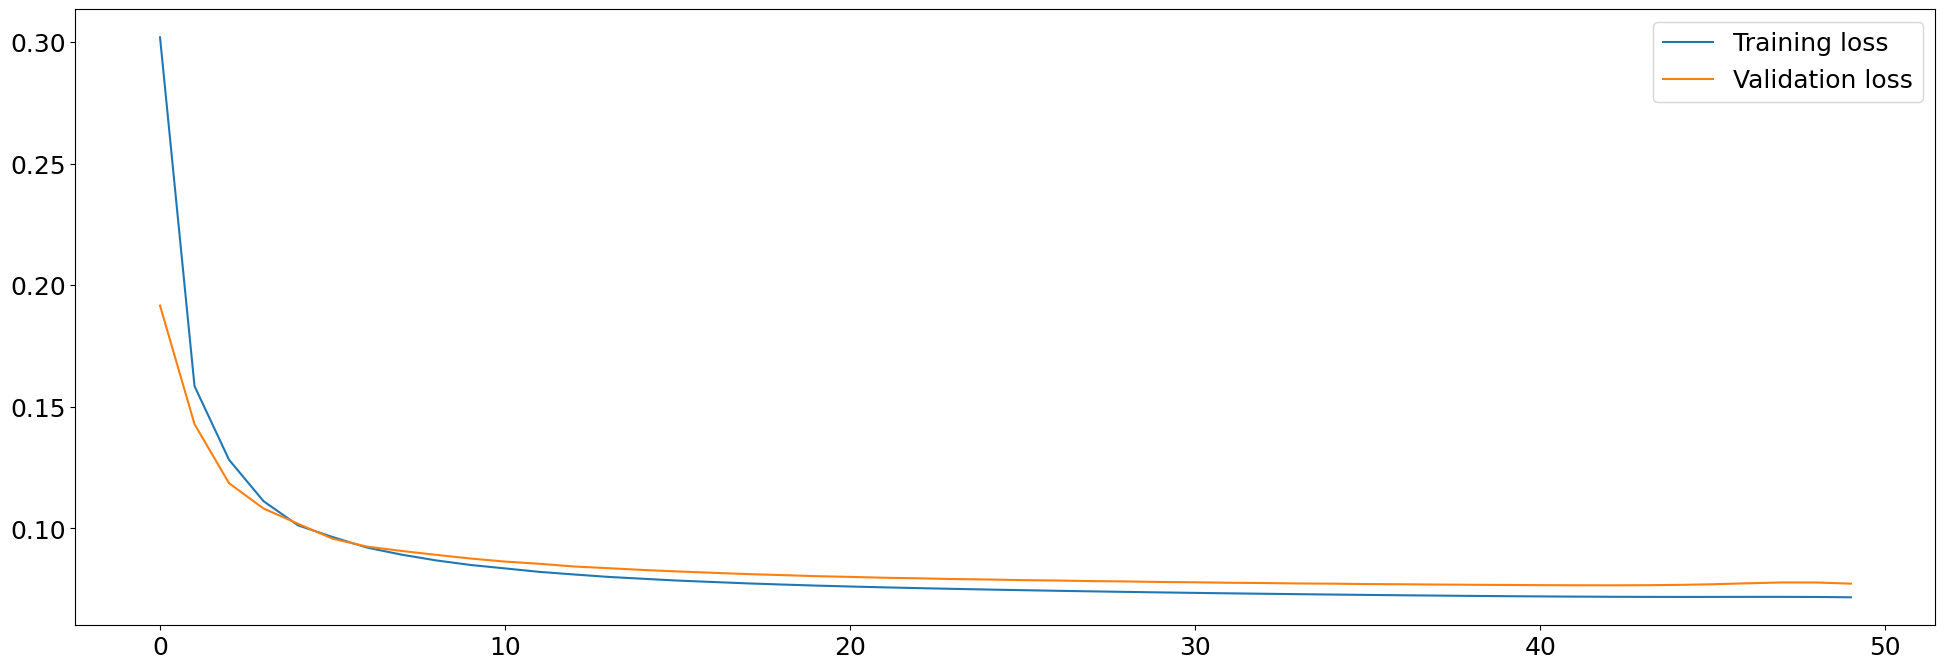

In [99]:
train(pyKAN, optim.Adam(pyKAN.parameters(), lr=0.05), epochs=50, false_neg_penalty=2.0)

Avg Test Score: 0.932
-------------------------
Accuracy:  0.981
Precision: 0.976
Recall:    0.977
F1-score:  0.976


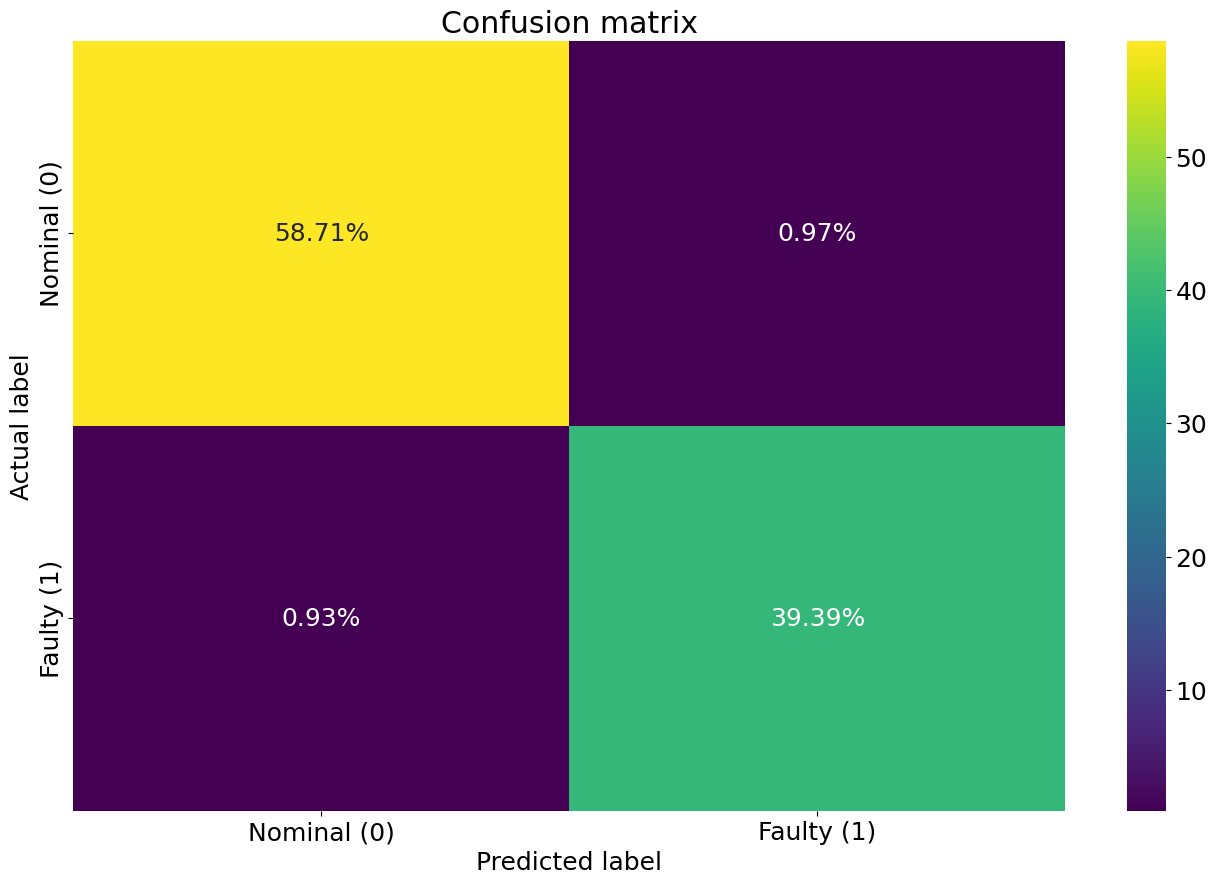

In [100]:
test(pyKAN)

In [ ]:
#pyKAN.model.saveckpt('models/pykan_simple_grid-5.pt')

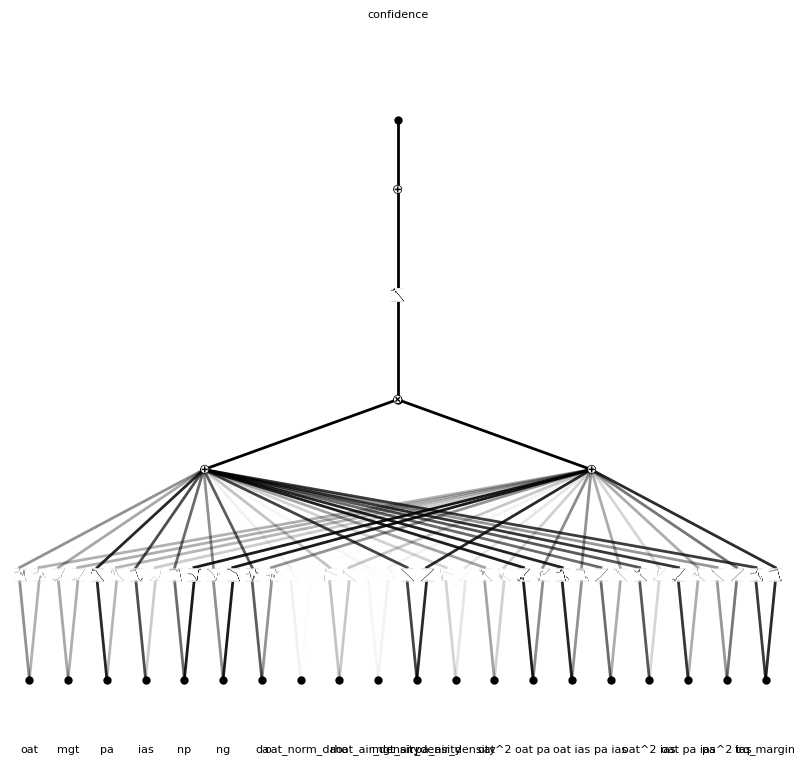

In [102]:
pyKAN.model.plot(
    scale=1,
    varscale=0.2,
    in_vars=selected_features_total,
    out_vars=['confidence']
)